In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


train_data = pd.read_csv("data_vectorized.csv")

In [2]:
tokens = train_data["tokens"].apply(eval)

flat_tokens = []
for i in tokens:
    flat_tokens.extend(i)

In [3]:
flat_tokens

['led',
 'woodi',
 'andi',
 'toy',
 'live',
 'happili',
 'room',
 'andi',
 'birthday',
 'bring',
 'buzz',
 'onto',
 'scene',
 'afraid',
 'lose',
 'place',
 'andi',
 'heart',
 'woodi',
 'plot',
 'buzz',
 'circumst',
 'separ',
 'buzz',
 'woodi',
 'owner',
 'duo',
 'eventu',
 'learn',
 'put',
 'asid',
 'differ',
 'sibl',
 'judi',
 'discov',
 'enchant',
 'board',
 'game',
 'open',
 'door',
 'magic',
 'world',
 'unwittingli',
 'invit',
 'alan',
 'adult',
 'trap',
 'insid',
 'game',
 '26',
 'year',
 'live',
 'room',
 'alan',
 'hope',
 'freedom',
 'finish',
 'game',
 'prove',
 'riski',
 'find',
 'run',
 'giant',
 'evil',
 'monkey',
 'terrifi',
 'creatur',
 'famili',
 'wed',
 'reignit',
 'ancient',
 'feud',
 'next',
 'door',
 'neighbor',
 'fish',
 'buddi',
 'max',
 'meanwhil',
 'sultri',
 'italian',
 'divorcé',
 'open',
 'restaur',
 'local',
 'bait',
 'shop',
 'alarm',
 'local',
 'worri',
 'scare',
 'fish',
 'away',
 'less',
 'interest',
 'cook',
 'hot',
 'time',
 'max',
 'cheat',
 'mistreat',

In [4]:
# create word 2 index dictionary for mapping later

wd2ix = dict()
ix2wd = dict()

wd2ix[-1] = -1
ix2wd[-1] = -1

cnt = 1
for words in set(flat_tokens):
    wd2ix[words] = cnt
    ix2wd[cnt] = words
    cnt+=1

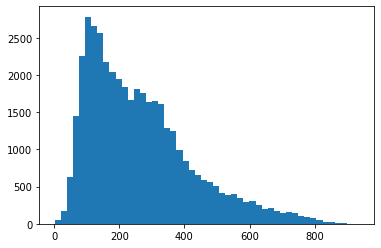

In [5]:
plt.hist(train_data["tokens"].apply(len), bins = 50)
plt.show()

In [6]:
cut_tokens = 60
padding = 0

tokens_aft_cut = []
for i in tokens:
    if len(i) >= cut_tokens:
        tokens_aft_cut.append([wd2ix[word] for word in i[:cut_tokens]])
    elif len(i) < cut_tokens:
        new_i = [wd2ix[word] for word in i]
        new_i += [padding for k in range(cut_tokens-len(i))]
        tokens_aft_cut.append(new_i)

In [7]:
data_X = pd.Series(tokens_aft_cut)
data_y = train_data["vec"].apply(eval)

In [8]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.9)

In [10]:
# Original code is from https://github.com/spro/practical-pytorch
import time
import math
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

#from name_dataset import NameDataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Parameters and DataLoaders
HIDDEN_SIZE = 100
N_CHARS = 9758  # ASCII
N_CLASSES = 17


class RNNClassifier(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        # Note: we run this all at once (over the whole input sequence)

        # input = B x S . size(0) = B
        batch_size = input.size(0)
        # input:  B x S  -- (transpose) --> S x B
        input = input.t()
        # Embedding S x B -> S x B x I (embedding size)
        print("  input", input.size())
        embedded = self.embedding(input)
        #print(embedded)

        # Make a hidden
        hidden = self._init_hidden(batch_size)
        print("embedded: {}, hidden: {}".format(embedded.size(), hidden.size()))
        output, hidden = self.gru(embedded, hidden)
        print("  gru hidden output", output.size())
        print(" gru hidden size: ", hidden.size())
        #print(output)
        # Use the last layer output as FC's input
        # No need to unpack, since we are going to use hidden
        fc_output = self.fc(hidden).reshape(batch_size,N_CLASSES)
        print("  fc output", fc_output.size())
        #print(fc_output)
        return torch.sigmoid(fc_output)

    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        return Variable(hidden)
    
    
inputs = Variable(torch.LongTensor(train_X.tolist()))
labels = Variable(torch.LongTensor(train_y.tolist()))

classifier = RNNClassifier(N_CHARS, HIDDEN_SIZE, N_CLASSES)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.5)

#labels = labels.squeeze(1)
for epoch in range(30):
    outputs = classifier(inputs)
    optimizer.zero_grad()
    print(outputs.size())
    loss = criterion(outputs, labels.float())
    loss.backward()
    optimizer.step()
    print(outputs)
    print("epoch: %d, loss: %1.3f" % (epoch + 1, loss.item()))
    print("Accuracy: ", ((outputs > .5)== labels).sum().tolist() / (labels.size(0) * labels.size(1)))
    #res = []
    #for i in range(len(outputs)):
    #    res.append([train_data.columns[4:-1][idx] for idx in (outputs[i]>.5).nonzero().flatten().tolist()])
    #print("Predicted : ", ''.join())

print("Learning finished!")    
    

  input torch.Size([60, 4193])
embedded: torch.Size([60, 4193, 100]), hidden: torch.Size([1, 4193, 100])
  gru hidden output torch.Size([60, 4193, 100])
 gru hidden size:  torch.Size([1, 4193, 100])
  fc output torch.Size([4193, 17])
torch.Size([4193, 17])
tensor([[0.4455, 0.4514, 0.4519,  ..., 0.5704, 0.5651, 0.5795],
        [0.4449, 0.4521, 0.4515,  ..., 0.5707, 0.5649, 0.5792],
        [0.4455, 0.4514, 0.4519,  ..., 0.5704, 0.5651, 0.5795],
        ...,
        [0.4455, 0.4514, 0.4519,  ..., 0.5704, 0.5651, 0.5795],
        [0.4454, 0.4515, 0.4519,  ..., 0.5705, 0.5651, 0.5794],
        [0.4429, 0.4534, 0.4511,  ..., 0.5693, 0.5647, 0.5783]],
       grad_fn=<SigmoidBackward>)
epoch: 1, loss: 0.921
Accuracy:  0.40376818507035533
  input torch.Size([60, 4193])
embedded: torch.Size([60, 4193, 100]), hidden: torch.Size([1, 4193, 100])
  gru hidden output torch.Size([60, 4193, 100])
 gru hidden size:  torch.Size([1, 4193, 100])
  fc output torch.Size([4193, 17])
torch.Size([4193, 17])
t

Accuracy:  0.8804029124170536
  input torch.Size([60, 4193])
embedded: torch.Size([60, 4193, 100]), hidden: torch.Size([1, 4193, 100])
  gru hidden output torch.Size([60, 4193, 100])
 gru hidden size:  torch.Size([1, 4193, 100])
  fc output torch.Size([4193, 17])
torch.Size([4193, 17])
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.8259e-36, 1.3267e-36, 2.3481e-36,  ..., 1.5948e-36, 2.4182e-36,
         4.1865e-36],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], grad_fn=<SigmoidBackward>)
epoch: 10, loss: 0.693
Accuracy:  0.8804029124170536
  input torch.Size([60, 4193])
embedd

        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<SigmoidBackward>)
epoch: 19, loss: 0.693
Accuracy:  0.8804029124170536
  input torch.Size([60, 4193])
embedded: torch.Size([60, 4193, 100]), hidden: torch.Size([1, 4193, 100])
  gru hidden output torch.Size([60, 4193, 100])
 gru hidden size:  torch.Size([1, 4193, 100])
  fc output torch.Size([4193, 17])
torch.Size([4193, 17])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<SigmoidBackward>)
epoch: 20, loss: 0.693
Accuracy:  0.8804029124170536
  input torch.Size([60, 4193])
embedded: torch.Size([60, 4193, 100]), hidden: torch.Size([1, 4193, 100])
  gru hidden output torch.Size([60, 4193, 100])
 gru hidden size:  torch.Size([1, 4193, 100])
  fc output torch.Size([4193, 17])
torch.Size([4193, 17])
tensor([[0., 0., 0.,  ..., 0., 